# A Network of Lookup Tables

In [2]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
import time
from tqdm import tqdm

%matplotlib inline

## Example 2

A network of k = 2 layers.
The first layer has 2 luts.
The second layer has 1 lut.

In [3]:
train_set = [([0,0,0],0),([0,0,0],1),([0,0,0],1),([0,0,1],1),([1,0,0],0),([1,1,0],0),([1,1,0],1)]
X_train = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,1],[1,0,0],[1,1,0],[1,1,0]])
y_train = np.array([0,1,1,1,0,0,1])

In [3]:
class LUT:
    def __init__(self, inputs, indexes_0, indexes_1, k , index = []):
        # build lut
        self.k = k
        if (index == []):
            self.index = np.sort(np.random.choice(len(inputs[0]),k,replace = False))
        else:
            self.index = index
        self.inv = np.arange(k-1,-1,-1)
        self.output = np.zeros((2**k), int)
        self.count_0 = np.zeros((2**k), int)
        self.count_1 = np.zeros((2**k), int)
        self.count(inputs[:,self.index], indexes_0,indexes_1)
        
    def count(self, subset, indexes_0, indexes_1):
        zeros = Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_0])))
        ones =  Counter(np.sort(self.get_index_vec_to_dec(subset[indexes_1])))
        for key in zeros.keys():
            self.count_0[key] = zeros[key]
        for key in ones.keys():
            self.count_1[key] = ones[key]
        # compute lut
        self.output[self.count_0 > self.count_1] = 0
        self.output[self.count_0 < self.count_1] = 1
        # picked uniformly at random
        self.output[self.count_0 == self.count_1] = np.random.choice([0,1], len(self.output[self.count_0 == self.count_1]))
        
    def get_index_vec_to_dec(self, X , axis = 1):
        dec_index = np.sum(X * np.power(2*np.ones(self.k,int),self.inv),axis= axis)
        return dec_index
    
    def get_index_dec_to_vec(self, dec):
        return "{0:b}".format(dec).zfill(self.k)
    
    def look(self, X):
        # X is a numpy array
        X = np.array(X)
        return self.output[self.get_index_vec_to_dec(X[self.index], 0)]
    
    def look_array(self, dataset):
        subdataset = dataset[:,self.index]
        return self.output[self.get_index_vec_to_dec(subdataset)]
        
    def score(self, labels, dataset):
        predicted = self.look_array(dataset)
        return accuracy_score(labels,predicted)
    
    def show(self):
        print("Look up table")
        print("Index = {}".format(self.index))
        print("  p    |  y0 |  y1 |  f   |")
        for i in range(len(self.output)):
            if (self.count_0[i] == self.count_1[i]):
                f = "{}*".format(self.output[i])
            else:
                f = "{} ".format(self.output[i])
            print("  {}   |  {}  |  {}  |  {}  |".format(self.get_index_dec_to_vec(i), self.count_0[i], self.count_1[i], f))
            
    def clean(self):
        self.count_0 = None
        self.count_1 = None

In [5]:
#index = np.sort(np.random.choice(len(train_set[0][0]),k,replace = False))
k = 2
index = [0,1]
lut = LUT(X_train,np.where(y_train == 0), np.where(y_train == 1), 2, index)
lut.show()
print("predict [0,0,0] : {}".format(lut.look(np.array([0,0,0]))))
print("accuracy : {}".format(lut.score(y_train, X_train)))

Look up table
Index = [0, 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  3  |  1   |
  01   |  0  |  0  |  0*  |
  10   |  1  |  0  |  0   |
  11   |  1  |  1  |  1*  |
predict [0,0,0] : 1
accuracy : 0.7142857142857143


In [6]:
n_luts = [2, 1] # number of luts per layer
k = 2 # sampling input

# make a Network of look up table
layers = []

indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)
outputs = np.zeros((len(X_train),n_luts[0]),int)

start = time.time()

# first layer
print(" ==== first layer === \n")
layer = []
for i in range(n_luts[0]):
    # build lut
    lut = LUT(X_train, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(X_train)
    lut.clean()
    layer.append(lut)
layers.append(layer)

# second layer
print("\n ==== second layer === \n")
layer = []
inputs = outputs
outputs = np.zeros((len(X_train),n_luts[1]),int)
for i in range(n_luts[1]):
    lut = LUT(inputs, indexes_0, indexes_1, k)
    lut.show()
    outputs[:,i] = lut.look_array(inputs)
    lut.clean()
    layer.append(lut)
layers.append(layer) 

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

 ==== first layer === 

Look up table
Index = [1 2]
  p    |  y0 |  y1 |  f   |
  00   |  2  |  2  |  0*  |
  01   |  0  |  1  |  1   |
  10   |  1  |  1  |  0*  |
  11   |  0  |  0  |  1*  |
Look up table
Index = [0 1]
  p    |  y0 |  y1 |  f   |
  00   |  1  |  3  |  1   |
  01   |  0  |  0  |  0*  |
  10   |  1  |  0  |  0   |
  11   |  1  |  1  |  0*  |

 ==== second layer === 

Look up table
Index = [0 1]
  p    |  y0 |  y1 |  f   |
  00   |  2  |  1  |  0   |
  01   |  1  |  2  |  1   |
  10   |  0  |  0  |  0*  |
  11   |  0  |  1  |  1   |
Time spent : 0.10s


## Experiment 1

A Network with 5 hidden layers of 1024 luts and 1 lut in the output layer. k = 9.

### Load MNIST

In [6]:
"""
def loadMNIST(prefix, folder):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images.idx3-ubyte', dtype = 'ubyte' )
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels.idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "./data/mnist" )
testImages, testLabels = loadMNIST( "t10k", "./data/mnist" )

from ipywidgets import FloatProgress
from IPython.display import display

X_train = np.zeros((60000,784), int)
y_train = np.zeros((60000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=trainingImages.shape[0])
display(f)
for i in range(trainingImages.shape[0]): 
    f.value+=1
    X_train[i,:]= 1.0*(trainingImages[i].reshape(784)>threshold)
y_train[trainingLabels>4] = 1
print(X_train.shape)

X_test = np.zeros((10000,784), int)
y_test = np.zeros((10000),int)
threshold=0.3 * 255
f = FloatProgress(min=0, max=testImages.shape[0])
display(f)
for i in range(testImages.shape[0]): 
    f.value+=1
    X_test[i,:]= 1.0*(testImages[i].reshape(784)>threshold)
y_test[testLabels>4] = 1
print(X_test.shape)

with open('./data/mnist/mnist_X_train.p', 'wb') as f:
    pickle.dump(X_train, f)
with open('./data/mnist/mnist_y_train.p', 'wb') as f:
    pickle.dump(y_train, f)
with open('./data/mnist/mnist_X_test.p', 'wb') as f:
    pickle.dump(X_test, f)
with open('./data/mnist/mnist_y_test.p', 'wb') as f:
    pickle.dump(y_test, f)
"""

'\ndef loadMNIST(prefix, folder):\n    intType = np.dtype( \'int32\' ).newbyteorder( \'>\' )\n    nMetaDataBytes = 4 * intType.itemsize\n\n    data = np.fromfile( folder + "/" + prefix + \'-images.idx3-ubyte\', dtype = \'ubyte\' )\n    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )\n    data = data[nMetaDataBytes:].astype( dtype = \'float32\' ).reshape( [ nImages, width, height ] )\n\n    labels = np.fromfile( folder + "/" + prefix + \'-labels.idx1-ubyte\',\n                          dtype = \'ubyte\' )[2 * intType.itemsize:]\n\n    return data, labels\n\ntrainingImages, trainingLabels = loadMNIST( "train", "./data/mnist" )\ntestImages, testLabels = loadMNIST( "t10k", "./data/mnist" )\n\nfrom ipywidgets import FloatProgress\nfrom IPython.display import display\n\nX_train = np.zeros((60000,784), int)\ny_train = np.zeros((60000),int)\nthreshold=0.3 * 255\nf = FloatProgress(min=0, max=trainingImages.shape[0])\ndisplay(f)\nfor i in range(trai

In [4]:
with open('./data/mnist/mnist_X_train.p', 'rb') as f:
    X_train = pickle.load(f)
with open('./data/mnist/mnist_y_train.p', 'rb') as f:
    y_train = pickle.load(f)
with open('./data/mnist/mnist_X_test.p', 'rb') as f:
    X_test = pickle.load(f)
with open('./data/mnist/mnist_y_test.p', 'rb') as f:
    y_test = pickle.load(f)

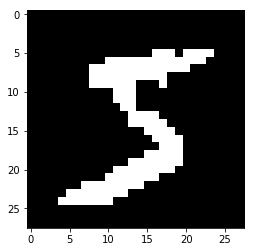

In [5]:
plt.imshow(X_train[0].reshape(28,28) , matplotlib.pyplot.cm.gray)

### Build Network

In [9]:
n_luts = [784,1024,1024,1024,1024,1024,1] # number of luts per layer
k = 8 # sampling input
layers = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

# input layer
l = 0
print("layer {} nb luts : {}".format(l, n_luts[l]))
layer = []
accuracy = []
inputs = X_train
outputs = np.zeros((len(y_train),n_luts[l]),int)
for i in tqdm(range(n_luts[0])):
    # build lut
    #lut = LUT(inputs, indexes_0, indexes_1, 1, index = [i])
    outputs[:,i] = inputs[:,i]
    #layer.append(lut)
    accuracy.append(accuracy_score(y_train, outputs[:,i]))
layers.append(layer)
train_accuracy.append(accuracy)

# 5 hidden layers + 1 output layer
for l in range(1,len(n_luts)):
    print("layer {} nb luts : {}".format(l, n_luts[l]))
    layer = []
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[l])):
        lut = LUT(inputs, indexes_0, indexes_1, k)
        outputs[:,i] = lut.look_array(inputs)
        layer.append(lut)
        accuracy.append(accuracy_score(y_train, outputs[:,i]))
    layers.append(layer)
    train_accuracy.append(accuracy)
    
end = time.time() - start
print("Time spent : {:.2f}s".format(end))

layer 0 nb luts : 784


100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [00:14<00:00, 53.35it/s]


layer 1 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:46<00:00,  9.60it/s]


layer 2 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:56<00:00,  8.62it/s]


layer 3 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:35<00:00, 13.24it/s]


layer 4 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:20<00:00, 12.66it/s]


layer 5 nb luts : 1024


100%|██████████████████████████████████████████████████████████████████████████████| 1024/1024 [01:19<00:00, 12.82it/s]


layer 6 nb luts : 1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]


Time spent : 494.30s


In [10]:
print("Experiment 1 : Training accuracy\n")
df = pd.DataFrame(train_accuracy).transpose()
df.describe()

Experiment 1 : Training accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.000000
mean,0.507220,0.611930,0.755167,0.843027,0.878318,0.892538,0.901167
std,0.036831,0.044454,0.019664,0.006983,0.003049,0.001253,NaN
min,0.402167,0.512433,0.666083,0.817333,0.868800,0.888633,0.901167
25%,0.495071,0.580229,0.742867,0.838279,0.876258,0.891683,0.901167
50%,0.509933,0.609592,0.757017,0.843017,0.878450,0.892550,0.901167
75%,0.513792,0.643104,0.768813,0.847692,0.880354,0.893367,0.901167
max,0.668500,0.739583,0.808800,0.862750,0.887567,0.897000,0.901167


In [14]:
# Compute test accuracy

# input layer
k = 8

test_accuracy = []

start = time.time()

inputs = X_test
outputs = np.zeros((len(X_test),n_luts[0]),int)
accuracy = []
for i in tqdm(range(n_luts[0])):
    outputs[:,i] = inputs[:,i]
    accuracy.append(accuracy_score(y_test, outputs[:,i]))
test_accuracy.append(accuracy)
    
for layer in layers[1:]:
    accuracy = []
    inputs = outputs
    outputs = np.zeros((len(X_test),len(layer)),int)
    for i in tqdm(range(len(layer))):
        score = layer[i].score(y_test, inputs)
        outputs[:,i] = layer[i].look_array(inputs)
        accuracy.append(score)
    test_accuracy.append(accuracy)

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.33it/s]


Time spent : 36.43s


In [15]:
print("Experiment 1 : Test accuracy\n")
df = pd.DataFrame(test_accuracy).transpose()
df.describe()

Experiment 1 : Test accuracy



,0,1,2,3,4,5,6
count,784.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,1.0000
mean,0.511235,0.615052,0.758190,0.842122,0.872814,0.881674,0.8842
std,0.038818,0.047724,0.020960,0.007557,0.003647,0.002053,NaN
min,0.391300,0.502400,0.657700,0.814300,0.861300,0.875500,0.8842
25%,0.497475,0.580900,0.745575,0.837475,0.870400,0.880375,0.8842
50%,0.513900,0.613200,0.760700,0.842300,0.873000,0.881600,0.8842
75%,0.517125,0.648450,0.772500,0.847300,0.875400,0.883100,0.8842
max,0.684600,0.749500,0.811500,0.864300,0.884100,0.888100,0.8842


## Experiment 2

k = 2,4,6,8,10,12,14,16

In [17]:
n_luts = [784,1024,1024,1024,1024,1024,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train == 0) 
indexes_1 = np.where(y_train == 1)

train_accuracy = []

start = time.time()

for k in k_list:
    layers = []
    interm = time.time()
    # input layer
    l = 0
    layer = []
    inputs = X_train
    outputs = np.zeros((len(y_train),n_luts[l]),int)
    outputs = inputs
    layers.append(layer)

    # 5 hidden layers + 1 output layer
    outputs = X_train
    for l in range(0,len(n_luts)):
        layer = []
        inputs = outputs
        outputs = np.zeros((len(y_train),n_luts[l]),int)
        for i in tqdm(range(n_luts[l])):
            lut = LUT(inputs, indexes_0, indexes_1, k)
            outputs[:,i] = lut.look_array(inputs)
            layer.append(lut)
        layers.append(layer)
    print(" Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_train, outputs)))
    train_accuracy.append(accuracy_score(y_train, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
    nn_list.append(layers)
    
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

 Memorization k = 2


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.78it/s]


accuracy :0.6928833333333333
Time spent :258.89s
 Memorization k = 4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


accuracy :0.8231833333333334
Time spent :373.63s
 Memorization k = 6


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


accuracy :0.86595
Time spent :391.11s
 Memorization k = 8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.90it/s]


accuracy :0.9038833333333334
Time spent :424.57s
 Memorization k = 10


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.43it/s]


accuracy :0.95345
Time spent :494.97s
 Memorization k = 12


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


accuracy :0.9919333333333333
Time spent :587.89s
 Memorization k = 14


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.76it/s]


accuracy :0.99935
Time spent :725.62s
 Memorization k = 16


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.00it/s]


accuracy :0.99995
Time spent :872.19s
Total Time spent : 4129.05s


In [19]:
len(nn_list[0][0])

0

In [18]:
# Compute test accuracy

# input layer
start = time.time()

test_accuracy = []

for n in range(len(nn_list)):
    
    layers = nn_list[n]
    k = k_list[n]
    interm = time.time()
    
    inputs = X_test
    outputs = np.zeros((len(X_test),n_luts[0]),int)
    for i in tqdm(range(n_luts[0])):
        outputs[:,i] = inputs[:,i]

    for layer in layers[1:]:
        inputs = outputs
        outputs = np.zeros((len(X_test),len(layer)),int)
        for i in tqdm(range(len(layer))):
            outputs[:,i] = layer[i].look_array(inputs)
            
    print(" Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_test, outputs)))
    test_accuracy.append(accuracy_score(y_test, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))   

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


 Memorization k = 2
accuracy :0.6965
Time spent :15.84s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


 Memorization k = 4
accuracy :0.8262
Time spent :17.40s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


 Memorization k = 6
accuracy :0.8657
Time spent :21.82s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


 Memorization k = 8
accuracy :0.8803
Time spent :26.61s


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


 Memorization k = 10
accuracy :0.8975
Time spent :29.15s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


 Memorization k = 12
accuracy :0.9021
Time spent :36.89s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


 Memorization k = 14
accuracy :0.8147
Time spent :54.57s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.03it/s]


 Memorization k = 16
accuracy :0.6662
Time spent :46.42s
Time spent : 248.85s


## Experiment 3

Experiment 2 with randomly permuted labels

In [6]:
y_test_random = np.random.permutation(y_test)
y_train_random = np.random.permutation(y_train)

In [7]:
n_luts = [784, 1024,1024,1024,1024,1024,1] # number of luts per layer
k_list = [2,4,6,8,10,12,14,16] # sampling input

nn_list = []

inputs = np.zeros((len(y_train),8),int)
indexes_0 = np.where(y_train_random == 0) 
indexes_1 = np.where(y_train_random == 1)

train_accuracy = []

start = time.time()

for k in k_list:
    layers = []
    interm = time.time()
    # input layer
    l = 0
    layer = []
    inputs = X_train
    outputs = np.zeros((len(X_train),n_luts[l]),int)
    for i in tqdm(range(n_luts[0])):
        # build lut
        outputs[:,i] = inputs[:,i]
    layers.append(layer)

    # 5 hidden layers + 1 output layer
    for l in range(1,7):
        layer = []
        inputs = outputs
        outputs = np.zeros((len(X_train),n_luts[l]),int)
        for i in tqdm(range(n_luts[l])):
            lut = LUT(inputs, indexes_0, indexes_1, k)
            outputs[:,i] = lut.look_array(inputs)
            layer.append(lut)
        layers.append(layer)
        
    print("Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_train_random, outputs)))
    train_accuracy.append(accuracy_score(y_train_random, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))
    nn_list.append(layers)
    
end = time.time() - start
print("Total Time spent : {:.2f}s".format(end))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.98it/s]


Memorization k = 2
accuracy :0.5111333333333333
Time spent :231.93s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.17it/s]


Memorization k = 4
accuracy :0.5265666666666666
Time spent :239.17s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


Memorization k = 6
accuracy :0.5500666666666667
Time spent :338.38s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


Memorization k = 8
accuracy :0.5964333333333334
Time spent :383.99s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.34it/s]


Memorization k = 10
accuracy :0.68775
Time spent :441.77s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.96it/s]


Memorization k = 12
accuracy :0.8302333333333334
Time spent :492.20s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


Memorization k = 14
accuracy :0.9327666666666666
Time spent :618.71s


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Memorization k = 16
accuracy :0.9731166666666666
Time spent :732.56s
Total Time spent : 3479.14s


In [9]:
# Compute test accuracy

# input layer
start = time.time()

test_accuracy = []

for n in range(len(nn_list)):
    
    layers = nn_list[n]
    k = k_list[n]
    interm = time.time()
    
    inputs = X_test
    outputs = np.zeros((len(X_test),n_luts[0]),int)
    for i in tqdm(range(n_luts[0])):
        outputs[:,i] = inputs[:,i]

    for layer in layers[1:]:
        inputs = outputs
        outputs = np.zeros((len(X_test),len(layer)),int)
        for i in tqdm(range(len(layer))):
            outputs[:,i] = layer[i].look_array(inputs)
            
    print("Memorization k = {}".format(k))
    print("accuracy :{}".format(accuracy_score(y_test_random, outputs)))
    test_accuracy.append(accuracy_score(y_test_random, outputs))
    
    end = time.time() - interm
    print("Time spent :{:.2f}s".format(end))   

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


Memorization k = 2
accuracy :0.5153
Time spent :5.92s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


Memorization k = 4
accuracy :0.5092
Time spent :8.85s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


Memorization k = 6
accuracy :0.5086
Time spent :11.53s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]


Memorization k = 8
accuracy :0.5052
Time spent :14.90s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.62it/s]


Memorization k = 10
accuracy :0.5069
Time spent :19.41s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 167.12it/s]


Memorization k = 12
accuracy :0.5089
Time spent :22.62s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.38it/s]


Memorization k = 14
accuracy :0.4948
Time spent :36.42s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.34it/s]


Memorization k = 16
accuracy :0.4996
Time spent :34.79s
Time spent : 154.48s


In [10]:
print(train_accuracy)
print(test_accuracy)

[0.5111333333333333, 0.5265666666666666, 0.5500666666666667, 0.5964333333333334, 0.68775, 0.8302333333333334, 0.9327666666666666, 0.9731166666666666]
[0.5153, 0.5092, 0.5086, 0.5052, 0.5069, 0.5089, 0.4948, 0.4996]


## Experiment 4

### Random guess

In [36]:
y_predict = np.random.choice([0,1], len(y_train))
print("Training accuracy : {}".format(accuracy_score(y_train, y_predict)))

y_predict = np.random.choice([0,1], len(y_test))
print("Test accuracy : {}".format(accuracy_score(y_test, y_predict)))

Training accuracy : 0.50145
Test accuracy : 0.4979


### Naive Bayes

In [38]:
from sklearn.naive_bayes import BernoulliNB

start = time.time()

clf = BernoulliNB()
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.76545
Test accuracy : 0.7683


### Logistic regression

In [40]:
from sklearn.linear_model import LogisticRegression

start = time.time()

clf = LogisticRegression()
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

C:\Users\flore\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy : 0.87005
Test accuracy : 0.8665


In [42]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9988666666666667
Test accuracy : 0.9656
Time spent : 7.87s


### 1-Nearest neighbor

In [3]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train[:10000], y_train[:10000])
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9699666666666666
Test accuracy : 0.9614
Time spent : 2213.41s


### 5-Nearest neighbor

In [5]:
from sklearn.neighbors import KNeighborsClassifier

start = time.time()

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train[:10000], y_train[:10000])
print("Training accuracy : {}".format(clf.score(X_train, y_train)))
print("Test accuracy : {}".format(clf.score(X_test, y_test)))

end = time.time() - start
print("Time spent : {:.2f}s".format(end))

Training accuracy : 0.9673333333333334
Test accuracy : 0.9617
Time spent : 2383.75s


### Conv net